On this notebook we'll analyze the data we've previously extracted and cleaned.

For that, let's first add a couple of libraries that we'll be using and import our dataset

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# We specify the columns to use, to avoid including the unnamed index column
df = pd.read_csv('data/processed_data.csv', usecols=['text', 'date', 'favorited', 'retweeted', 'replies', 'user', 'lang'])

In [3]:
df.head()

,text,date,favorited,retweeted,replies,user,lang
0,"Los ""pollos"" queremos un Presidente ""pollo"". U...",2018-01-27 22:24:45,629,336,85,708108228568207360,es
1,Vota por @IvanDuque en la consulta @CeDemocrat...,2018-01-27 21:51:25,793,535,136,149281495,es
2,Compartimos con alegría nuestra propuesta de p...,2018-01-27 21:50:15,188,119,4,77653794,es
3,.@FNAraujoR #4 Senado @IvanDuque #ElCandidato...,2018-01-27 21:46:13,34,27,2,1069678676,es
4,The girls flocking to see Mr. Duque. That's g...,2018-01-27 20:54:10,1,0,0,876674787115925504,en


In [4]:
# We convert the date column to have date format
df['date'] = pd.to_datetime(df['date'])

In [5]:
# And we use it as the index for the dataset
df.set_index('date', inplace=True)

And now we're ready to start exploring our data.

# Basic analysis

Let's look at some basic statistics first

In [6]:
df.describe()

,favorited,retweeted,replies,user
count,27695.000000,27695.000000,27695.000000,2.769500e+04
mean,272.659289,141.743022,24.384871,1.101582e+17
std,818.115387,368.529151,91.420453,2.906389e+17
min,0.000000,0.000000,0.000000,7.820760e+05
25%,21.000000,10.000000,1.000000,1.145778e+08
50%,59.000000,34.000000,3.000000,2.847087e+08
75%,189.000000,112.000000,13.000000,1.668436e+09
max,28728.000000,9909.000000,3242.000000,1.006637e+18


From this, we can see a couple of things. For example, we can see that the mean of likes is strongly affected by outliers. This can be seen in that our third quartile is at 189 likes, and the mean is at 272. This means that the mean is being pulled greatly by the most favorited tweets.

The same happens with the number of retweets.

Let's see the count of tweets in the different languages Twitter identified

In [7]:
df['lang'].value_counts()

es     24287
en      3058
und      287
pt        35
ca         8
fr         5
it         4
tl         3
et         3
in         2
hu         1
no         1
ht         1
Name: lang, dtype: int64

So according to this, there are tweets in various languages mentioning the presidential candidates. However, if we examine them, we'll see that many are misclassified. For instance let's take a look at the tweets classified as catalan:

In [8]:
for text in df[df['lang'] == 'ca']['text']:
    print("=" * 80)
    print(text)
    print("=" * 80)

La gran fórmula. @MJaramilloLujan @Ricardo_Rojas_E @IvanDuque @AlvaroUribeVel @claudiapalacios @Cusugagutierrez @majagual @jcjurado1 pic.twitter.com/aO4yoc9wan
TOTAL !!!
Comite voluntarios Duitsma Cívica Con Duque @AlvaroUribeVel @IvanDuque @CIROARAMIREZ @CeDemocratico @CeDemocratico @Ricardo7dias @boyacasietedias pic.twitter.com/duzrSu0BVD
Atacó - Tolima                                        Comité Voluntario-S/ Construccion  @IvanDuque Pte @mluciaramirez VicePte                             @CeDemocratico @ComiteCivDura pic.twitter.com/dUfBTmsORl
Toma Comuna 12 #Bucaramanga @IvanDuque #DuquePresidenteEnPrimeraVuelta @EdwBallesteros #YoRespondoPorSantander @GermanEspejo_ @SophyCh_E @linamcardonag @totorangelm @Setulus1 pic.twitter.com/uLakIgn9mL
#PetroEnBoyaca Duitama con #ColombiaHumana @petrogustavo pic.twitter.com/vhncSAGxhD
"EL" INNOMBRABLE @AlvaroUribeVel AUCD  NHM @FiscaliaCol ? @gener_usuga @AlirioUribeMuoz @IvanCepedaCast @petrogustavo @IndiraVegaP @EsperancitaUrib @adrisgame 

These are all actually in spanish, but, probably because of the short text, Twitter is misclassifying them.

### Adding the tweet length

Let's add the length of the tweets as an extra column to our dataframe, to see if it might give some insight

In [9]:
df['length'] = df['text'].str.len()

df.head()

,text,favorited,retweeted,replies,user,lang,length
date,,,,,,,
2018-01-27 22:24:45,"Los ""pollos"" queremos un Presidente ""pollo"". U...",629,336,85,708108228568207360,es,197.0
2018-01-27 21:51:25,Vota por @IvanDuque en la consulta @CeDemocrat...,793,535,136,149281495,es,121.0
2018-01-27 21:50:15,Compartimos con alegría nuestra propuesta de p...,188,119,4,77653794,es,190.0
2018-01-27 21:46:13,.@FNAraujoR #4 Senado @IvanDuque #ElCandidato...,34,27,2,1069678676,es,300.0
2018-01-27 20:54:10,The girls flocking to see Mr. Duque. That's g...,1,0,0,876674787115925504,en,50.0


And now we've got a length column with the length of each tweet.

### Adding columns to identify the mentioned candidates

Now let's add an extra couple of columns to tell if one of the candidates is mentioned (or if both are). We'll call these 'mentions_duque' and 'mentions_petro'.

In [10]:
df['mentions_duque'] = df['text'].str.lower().str.contains('@ivanduque')
df['mentions_petro'] = df['text'].str.lower().str.contains('@petrogustavo')

# Let's set those columns as boolean
df['mentions_duque'] = df['mentions_duque'].astype('bool')
df['mentions_petro'] = df['mentions_petro'].astype('bool')

df.tail(10)

,text,favorited,retweeted,replies,user,lang,length,mentions_duque,mentions_petro
date,,,,,,,,,
2018-06-17 23:37:36,Un claro triunfo de @IvanDuque . Una gran vota...,146,75,7,70594101,es,233.0,True,True
2018-06-17 23:37:08,"#ENVIVO ""Gracias a todos en el exterior, a los...",195,39,4,14834302,es,147.0,False,True
2018-06-17 23:36:37,El guerrillero @petrogustavo tiene derecho a d...,134,135,3,2388386342,es,271.0,False,True
2018-06-17 23:36:32,"Según el 99,92% de los votos escrutados, en #B...",162,155,49,76664119,es,214.0,True,True
2018-06-17 23:36:00,Quien le dijo a @petrogustavo q había ganado e...,28,36,2,99845052,es,111.0,False,True
2018-06-17 23:35:56,El discurso de @petrogustavo ratifica que él n...,91,72,4,123696230,es,163.0,False,True
2018-06-17 23:35:48,"You’re a fucking shit, I can’t understand how ...",1,0,0,752702142130036736,en,112.0,False,False
2018-06-17 23:35:22,"""La corrupción en Colombia está herida; la cla...",148,48,8,9633802,es,125.0,False,True
2018-06-17 23:35:11,"#ColombiaDecide | ""Esperamos que sea cierto qu...",108,29,6,18079284,es,208.0,False,True


Now we've got columns indicating which of the candidates is being mentioned, or if they both are.

Apparently, some tweets do not mention either of the candidates. Let's check those out to see if we should get rid of them.

In [11]:
for tweet in df[~df['mentions_duque'] & ~df['mentions_petro']]['text'][:10]:
    print(tweet)

Compartimos con alegría nuestra propuesta de país en #Medellín, juntos vamos a construir un país de #legalidad #emprendimiento y #equidad #ManoFirme #CorazónGrande pic.twitter.com/7JZKfbxiYR
The girls flocking to see Mr. Duque.  That's good.
Nuestro gobierno incentivará la inversión y el emprendimiento, buscará, con una agenda integral de recuperación económica y con responsabilidad fiscal, bajar impuestos y mejorar el salario de los trabajadores #Medellín pic.twitter.com/DFEW7027qU
Nosotros necesitamos volver a sembrar valores, a generar una cultura  de respeto a la ley, al prójimo, a la mujer. En nuestro gobierno le vamos a devolver al sistema educativo las cátedras de cívica y urbanidad para formar ciudadanos ejemplares #Medellín #Antioquia pic.twitter.com/BccKObHfib
Si el ELN se quiere desmovilizar, desarmar y reinsertar, que se concentre, suspenda actividades criminales y que se sometan a penas proporcionales y efectivas. Sino lo aceptan les caerá toda la capacidad ofensiva del Es

Some of these tweets were created by one of the candidates. So, let's get rid of the tweets created by the candidates, since we're not really interested on their sentiment towards one another.

In [12]:
df.drop(df[(df['user'] == 77653794) | (df['user'] == 49849732)].index, axis=0, inplace=True)

Now, let's check the tweets not mentioning any of the candidates again

In [13]:
for tweet in df[~df['mentions_duque'] & ~df['mentions_petro']]['text'][:10]:
    print(tweet)

The girls flocking to see Mr. Duque.  That's good.
Fajardo petardo google
The Winner is ; @A_OrdonezM  sin duda!!
No worries then
¡Horror!
El doctorcito Google.
Exacto
Yo tuve la oportunidad de leer el libro de Indignaccion con sus 162 propuestas (plan de gobierno) para la economía, educación, salud, empleo, cultura, agro, etc. El man la tiene clara.
Por eso lo dije quienes lo difaman no lo han escuchado como sabe de cada tema que le preguntan
Uichhhhhhj qué genio, si se le frota salen naranjas jajajajajaja jajajajajaja jajajajajajaja jajajja ya veo q #No trabajan sobre presión. Ja


In [14]:
df[~df['mentions_duque'] & ~df['mentions_petro']]

,text,favorited,retweeted,replies,user,lang,length,mentions_duque,mentions_petro
date,,,,,,,,,
2018-01-27 20:54:10,The girls flocking to see Mr. Duque. That's g...,1,0,0,876674787115925504,en,50.0,False,False
2018-01-27 18:05:48,Fajardo petardo google,1,0,0,116084446,en,22.0,False,False
2018-01-27 21:57:34,The Winner is ; @A_OrdonezM sin duda!!,1,0,0,118819583,en,39.0,False,False
2018-01-27 14:19:19,No worries then,0,0,0,234114512,en,15.0,False,False
2018-01-27 12:51:49,¡Horror!,2,2,2,185859540,en,8.0,False,False
2018-01-27 12:02:31,El doctorcito Google.,0,0,1,1249867920,en,21.0,False,False
2018-01-27 03:36:35,Exacto,1,0,0,2352871707,en,6.0,False,False
2018-01-27 00:08:44,Yo tuve la oportunidad de leer el libro de Ind...,1,0,0,1012007906,es,184.0,False,False
2018-01-27 00:08:41,Por eso lo dije quienes lo difaman no lo han e...,1,0,0,872771798,es,94.0,False,False


This reveals very important information, because these tweets, are replies to the candidates, which are crucial to our analysis. So, we'll need to update the data extractor to include this information as well. But for now, let's work with what we already have.

### Analyzing the tweets' length

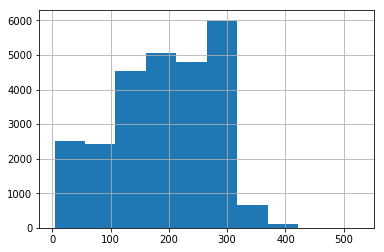

In [15]:
df['length'].hist()

According to this histogram, the tweet length has a sort of skewed distribution, with a mode near the 300 characters.

Now let's see if anything varies between the candidates or if it's rather similar.

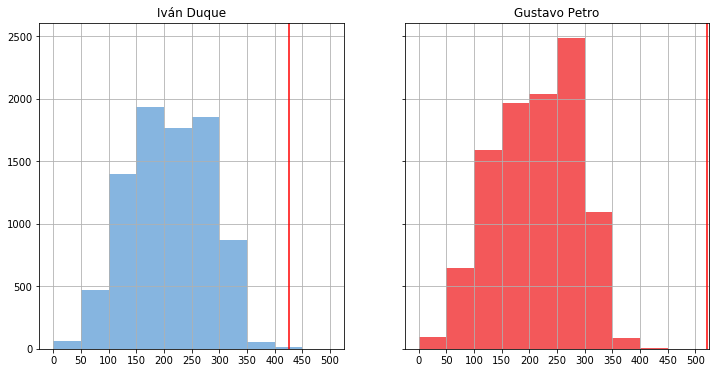

In [16]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

xticks = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

df[df['mentions_duque'] & ~df['mentions_petro']]['length'].hist(ax=ax, color='#86B5E0', bins=xticks)
df[df['mentions_petro'] & ~df['mentions_duque']]['length'].hist(ax=ax2, color='#F3585A', bins=xticks)

# Add a vertical line to mark the max length
ax.axvline(max(df[df['mentions_duque'] & ~df['mentions_petro']]['length']), color='red')
ax.set(xticks=xticks, title='Iván Duque')

ax2.axvline(max(df[df['mentions_petro'] & ~df['mentions_duque']]['length']), color='red')
ax2.set(xticks=xticks, title='Gustavo Petro')

plt.show()

From these histograms we can see that the length of the tweets is basically a normal distribution, however, there's something with tweets mentioning Gustavo Petro, which had an abnormal amount of tweets between 250 and 300 characters. Also, it's possible to see that the longest tweets mentioned Gustavo Petro more than Ivan Duque. However, this is probably justified by the overall difference between the amount of tweets mentioning each of the candidates.

## Identifying most frequent words

Now, let's identify which words were used the most by the people mentioning the candidates.

For this, we'll need to create a corpus of the tweets mentioning each of the candidates; remove stopwords; and calculate the frequencies.

1. Creating corpus for the tweets mentioning the different candidates.

We'll create three different corpuses here. The first one will contain tweets mentioning just one of the candidates; the second one will contain tweets mentioning just the other candidate; and the third one will contain all of the tweets.

In [55]:
# First, remove columns without a text value
df = df[~df['text'].isnull()]

duque_corpus = " ".join(df[df['mentions_duque'] & ~ df['mentions_petro']]['text'])
petro_corpus = " ".join(df[df['mentions_petro'] & ~ df['mentions_duque']]['text'])
corpus = " ".join(df['text'])

Now, let's see what happens if we try to tokenize the text by simply using `*_corpus.split()`

In [47]:
duque_corpus.split()

['Los',
 '"pollos"',
 'queremos',
 'un',
 'Presidente',
 '"pollo".',
 'Un',
 'pollo',
 'fresco',
 'e',
 'innovador',
 'pero',
 'con',
 'las',
 'espuelas',
 'puestas',
 'por',
 '@AlvaroUribeVel',
 'Ese',
 '"pollo"',
 'es',
 '@IvanDuque',
 '#DuquePresidente',
 '@CeDemocratico',
 '@CarlosHolmesTru',
 'Vota',
 'por',
 '@IvanDuque',
 'en',
 'la',
 'consulta',
 '@CeDemocratico',
 'el',
 'partido',
 'del',
 'Uribismo',
 'y',
 'de',
 '@AlvaroUribeVel',
 'pic.twitter.com/7CzVECAOHu',
 '.@FNAraujoR',
 '#4',
 'Senado',
 '@IvanDuque',
 '#ElCandidatoDeLaEsperanza',
 '#1',
 'en',
 'la',
 'Consulta',
 'Interpartidista',
 '@AlvaroUribeVel',
 '#',
 '1',
 'Senado',
 '.@CeDemocratico',
 ',',
 'están',
 'sembrando',
 'Esperanza',
 'en',
 'cada',
 'Rincón',
 'de',
 'La',
 'Patria',
 'para',
 'que',
 'los',
 'tiempos',
 'de',
 'la',
 'Seguridad',
 'Democrática',
 'Regrese.',
 '#LoMejorEstaPorVenir',
 'pic.twitter.com/RWrmqrwYfm',
 '#FelizSábado,',
 'hoy',
 'durante',
 'reunión',
 'en',
 'Medellín',
 'el',
 

As you may see, we'll get some words wrapped in quotes, such as `"pollos"`, we'll get some words followed or preceded by periods, commas, or other punctuation marks, such as `.@CeDemocratico`, `#FelizSábado,`, `!Trabaremos`, `municipios!`, and others.

So, let's actually convert the corpuses into arrays by using `split()` and then clean them up a little

In [56]:
split_duque_corpus, split_petro_corpus, split_corpus = duque_corpus.split(), petro_corpus.split(), corpus.split()

print(len(split_duque_corpus), len(split_petro_corpus), len(split_corpus))

230650 283820 676107


Great. Now, let's define a function to remove these special characters.

In [57]:
import re

def remove_special_characters(input_corpus):
    period = re.compile("(\.|\:)")
    for (i, v) in enumerate(input_corpus):
        # We remove periods only if they're at the first or last position
        if period.match(v, 0, 1):
            v = v[1:]
        if period.match(v, len(v) - 1, len(v)):
            v = v[:-1]
        # And we remove special characters other than periods, hash signs, ad signs, letters with tildes, and numbers
        v = re.sub("[^\:a-zA-Z0-9áéíóúüñÁÉÍÓÚÑ\.#@\/]", "", v)
        # Finally, we keep the lowercase version of the word
        input_corpus[i] = v.lower()
    return input_corpus

And now we can clean the corpuses

In [58]:
clean_duque_corpus = remove_special_characters(split_duque_corpus)

clean_petro_corpus = remove_special_characters(split_petro_corpus)

clean_corpus = remove_special_characters(split_corpus)

In [59]:
clean_duque_corpus

['los',
 'pollos',
 'queremos',
 'un',
 'presidente',
 'pollo',
 'un',
 'pollo',
 'fresco',
 'e',
 'innovador',
 'pero',
 'con',
 'las',
 'espuelas',
 'puestas',
 'por',
 '@alvarouribevel',
 'ese',
 'pollo',
 'es',
 '@ivanduque',
 '#duquepresidente',
 '@cedemocratico',
 '@carlosholmestru',
 'vota',
 'por',
 '@ivanduque',
 'en',
 'la',
 'consulta',
 '@cedemocratico',
 'el',
 'partido',
 'del',
 'uribismo',
 'y',
 'de',
 '@alvarouribevel',
 'pic.twitter.com/7czvecaohu',
 '@fnaraujor',
 '#4',
 'senado',
 '@ivanduque',
 '#elcandidatodelaesperanza',
 '#1',
 'en',
 'la',
 'consulta',
 'interpartidista',
 '@alvarouribevel',
 '#',
 '1',
 'senado',
 '@cedemocratico',
 '',
 'están',
 'sembrando',
 'esperanza',
 'en',
 'cada',
 'rincón',
 'de',
 'la',
 'patria',
 'para',
 'que',
 'los',
 'tiempos',
 'de',
 'la',
 'seguridad',
 'democrática',
 'regrese',
 '#lomejorestaporvenir',
 'pic.twitter.com/rwrmqrwyfm',
 '#felizsábado',
 'hoy',
 'durante',
 'reunión',
 'en',
 'medellín',
 'el',
 'expresident

In [60]:
# We create a couple of dicts to store the word frequencies
duque_freq = {}
petro_freq = {}
whole_freq = {}

# We populate the word frequency map
for word in clean_duque_corpus:
    duque_freq[word] = duque_freq.get(word, 0) + 1

for word in clean_petro_corpus:
    petro_freq[word] = petro_freq.get(word, 0) + 1
    
for word in clean_corpus:
    whole_freq[word] = whole_freq.get(word, 0) + 1

Now let's see what that gives us

In [61]:
duque_freq

{'los': 2830,
 'pollos': 1,
 'queremos': 147,
 'un': 1739,
 'presidente': 1496,
 'pollo': 34,
 'fresco': 5,
 'e': 234,
 'innovador': 3,
 'pero': 290,
 'con': 3382,
 'las': 1857,
 'espuelas': 4,
 'puestas': 4,
 'por': 3225,
 '@alvarouribevel': 1233,
 'ese': 139,
 'es': 2109,
 '@ivanduque': 8416,
 '#duquepresidente': 762,
 '@cedemocratico': 1057,
 '@carlosholmestru': 92,
 'vota': 123,
 'en': 5407,
 'la': 7712,
 'consulta': 488,
 'el': 6111,
 'partido': 184,
 'del': 1734,
 'uribismo': 62,
 'y': 6524,
 'de': 11120,
 'pic.twitter.com/7czvecaohu': 1,
 '@fnaraujor': 81,
 '#4': 6,
 'senado': 253,
 '#elcandidatodelaesperanza': 5,
 '#1': 16,
 'interpartidista': 27,
 '#': 60,
 '1': 168,
 '': 2292,
 'están': 166,
 'sembrando': 3,
 'esperanza': 300,
 'cada': 145,
 'rincón': 12,
 'patria': 143,
 'para': 2540,
 'que': 4987,
 'tiempos': 18,
 'seguridad': 178,
 'democrática': 62,
 'regrese': 2,
 '#lomejorestaporvenir': 1,
 'pic.twitter.com/rwrmqrwyfm': 1,
 '#felizsábado': 8,
 'hoy': 564,
 'durante': 45

Great! That's exactly what we needed.

Now, as you may see, stopwords such as los, es, la, en, have the hightest frequencies. so, we should remove those

NLTK provides spanish stopwords. So we'll use those to filter out our frequency dicts.

We'll just remove the word 'estado' from the stopwords, since it might be important on this context

In [138]:
from nltk.corpus import stopwords

stopwds = stopwords.words('spanish')

extra_words = ['si', 'sí', '', 'hoy', 'q', 'd', 'ser', 'va', 'ahora', 'así', 'usted', 'the', 'ver', 'tan', 'cómo', 'vez', 'toda', 'van', 'cada', 'día', 'todas', '11', '1', '#1', 'to', 'of', 'in', 'después', 'da', 'and', 'is', 'ud', 'petro', '@petrogustavo', 'duque', '@ivanduque', 'vamos']

stopwds.remove('estado')

stopwds += extra_words

And now let's simply filter the dicts

In [139]:
duque_freq_no_stopwords = {k: v for k, v in duque_freq.items() if k not in stopwds}

petro_freq_no_stopwords = {k: v for k, v in petro_freq.items() if k not in stopwds}

whole_freq_no_stopwords = {k: v for k, v in whole_freq.items() if k not in stopwds}

In [140]:
most_frequent = {
    'duque': sorted(duque_freq.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_freq.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_freq.items(), key=lambda kv: kv[1], reverse=True)
}

most_frequent_no_stopwords = {
    'duque': sorted(duque_freq_no_stopwords.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_freq_no_stopwords.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_freq_no_stopwords.items(), key=lambda kv: kv[1], reverse=True)
}

In [141]:
most_frequent_no_stopwords['duque']

[('@mluciaramirez', 1673),
 ('colombia', 1585),
 ('presidente', 1496),
 ('@alvarouribevel', 1233),
 ('@cedemocratico', 1057),
 ('candidato', 963),
 ('país', 833),
 ('#duquepresidente', 762),
 ('campaña', 627),
 ('gran', 575),
 ('#duqueeselquees', 568),
 ('vuelta', 493),
 ('consulta', 488),
 ('votar', 484),
 ('colombianos', 455),
 ('vicepresidente', 401),
 ('gobierno', 400),
 ('propuestas', 389),
 ('presidencia', 385),
 ('primera', 366),
 ('mejor', 362),
 ('futuro', 357),
 ('apoyo', 321),
 ('voto', 321),
 ('gracias', 311),
 ('esperanza', 300),
 ('presidencial', 288),
 ('ganar', 288),
 ('próximo', 286),
 ('marzo', 285),
 ('senado', 253),
 ('uribe', 242),
 ('mayo', 239),
 ('@germanvargas', 226),
 ('27', 220),
 ('política', 218),
 ('candidatos', 212),
 ('voluntarios', 209),
 ('rumbo', 198),
 ('bogotá', 193),
 ('@movimientomira', 192),
 ('recuperar', 191),
 ('emprendimiento', 189),
 ('solo', 185),
 ('partido', 184),
 ('hacer', 180),
 ('seguridad', 178),
 ('debate', 177),
 ('corrupción', 175

Let's now define a function that allows us to visualize this information.

In [146]:
def plot_data(key):
    ypos = np.arange(50)

    fig, ax = plt.subplots(figsize=(14, 15))
    
    data = dict(most_frequent_no_stopwords[key][:50])

    ax.barh(ypos, list(data.values()), align='center')
    ax.set_yticks(ypos)
    ax.set_yticklabels(list(data.keys()))
    ax.set_xlabel('Frecuencia')
    ax.invert_yaxis()
    ax.set_title("Palabras más frecuentes en los tweets de: '{}'".format(key))

    plt.show()

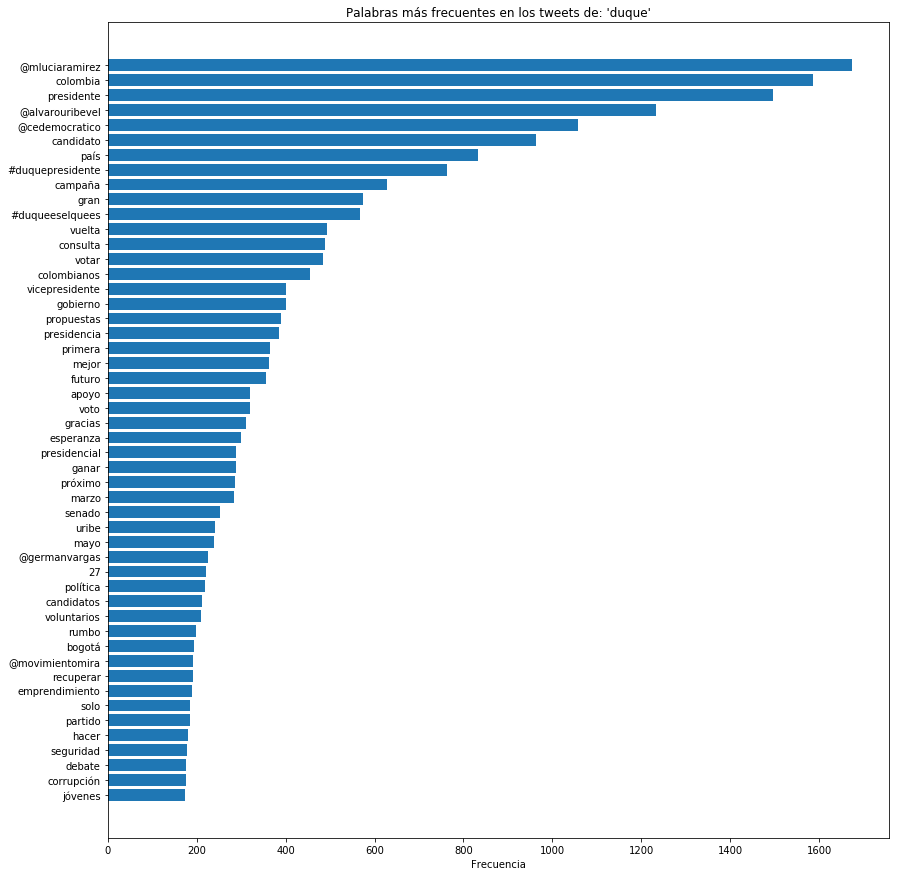

In [147]:
plot_data('duque')

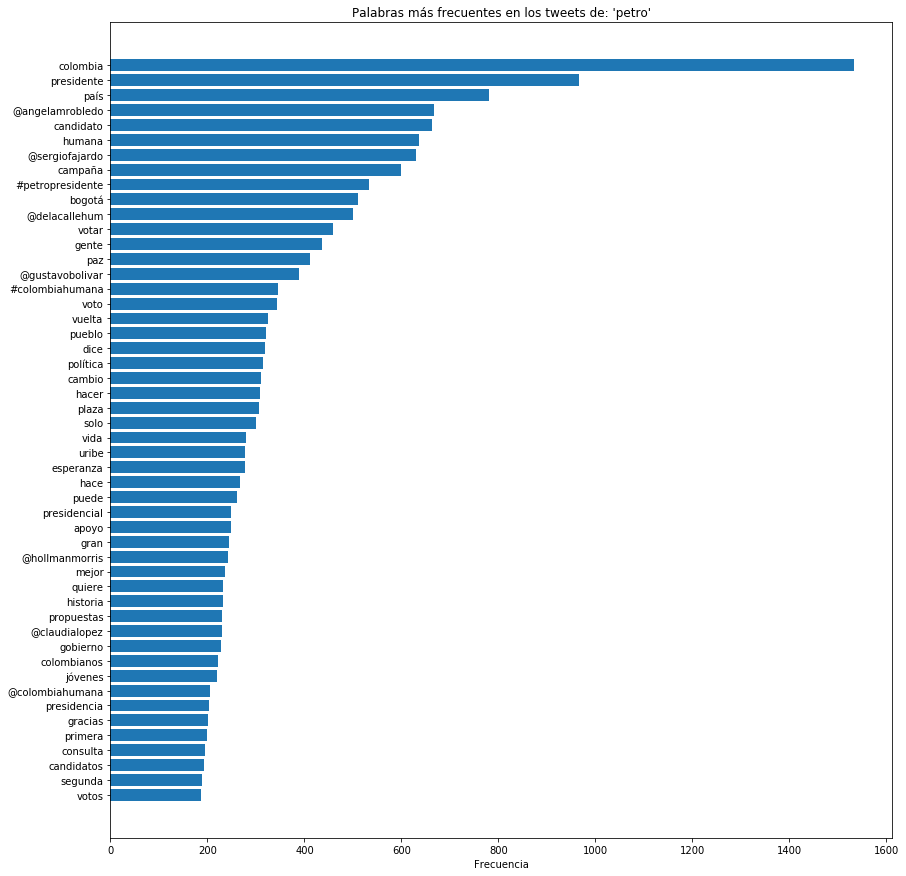

In [148]:
plot_data('petro')

In [62]:
import textblob

In [44]:
for t in df['text']:
    print(t + "\n")

Los "pollos" queremos un Presidente "pollo". Un pollo fresco e innovador pero con las espuelas puestas por @AlvaroUribeVel Ese "pollo" es @IvanDuque #DuquePresidente @CeDemocratico @CarlosHolmesTru

Vota por @IvanDuque en la consulta @CeDemocratico el partido del Uribismo y de @AlvaroUribeVel pic.twitter.com/7CzVECAOHu

.@FNAraujoR  #4 Senado @IvanDuque #ElCandidatoDeLaEsperanza  #1 en la Consulta Interpartidista @AlvaroUribeVel  # 1 Senado .@CeDemocratico , están sembrando Esperanza en cada Rincón de La Patria para que los tiempos de la Seguridad Democrática Regrese. #LoMejorEstaPorVenir pic.twitter.com/RWrmqrwYfm

The girls flocking to see Mr. Duque.  That's good.

#FelizSábado, hoy durante reunión en Medellín el expresidente @AlvaroUribeVel y el Candidato @IvanDuque reiteraron nuestro compromiso por recuperar la seguridad del país. pic.twitter.com/yed48GqJ0B

Fajardo petardo google

"Colombia necesita por lo menos 7 cárceles más" @IvanDuque pic.twitter.com/Fk3R1ZW7dW

"La ley 100 le


El próximo domingo 11 de marzo los colombianos tenemos en nuestras manos la oportunidad de recuperar el rumbo de nuestro país. Al congreso invito a votar por @Juan_EspinalR #CámaraPorAntioquiaCD116 y @PaolaHolguin #SenadoCD6. En la consulta por @IvanDuque pic.twitter.com/fbDEzVPujH

Con @IvanDuque vamos a impulsar, subir el subsidio del adulto mayor. pic.twitter.com/1zRZtK8LcH

Este 11 de marzo recuerda pedir el tarjetón para la consulta por Colombia, y vota por @IvanDuque El presidente que merece y necesita Colombia.   #DuqueEsElQueEs #DuquePresidente pic.twitter.com/A9SJkyRDuJ

"THAT LINE IN THE MIDDLE OF THE ROAD, IS THE WORST PLACE TO DRIVE" .....

La incoherencia de algunos no tiene límites primero decían que @IvanDuque distaba del pensamiento de Uribe, ahora qué es el candidato único y anda con el jefe por toda Colombia, el infiltrado es él propio Uribe. Que locura! pic.twitter.com/dAcYVmZ03m

Yo lo he dicho muchas veces, yo votaré por @IvanDuque. Pero si no queda como candidato

Nuestro próximo Presidente @IvanDuque NO MIENTE sobre su educación. Si a usted le preguntan, “muestre sus postgrados”, ¡usted los muestra!! #DuqueEsElQueEs pic.twitter.com/eYDAGt4tda

Señor @RoyBarreras, le aclaro a quien le queremos quitar la representación: a los corruptos como usted, que se escogen comprando votos y llegan a robar. Con @IvanDuque, no va haber espacio para la politiquería y el clientelismo que tanto le gusta a usted. Que le quede muy claro pic.twitter.com/NIqwLnSKZw

La corrupción sin Barreras critica las propuestas de una sola Corte con varias salas y la reducción del Congreso. Más razones para votar por @IvanDuque. Derrotemos a los corruptos sin Barreras.

Los títulos chimbos del borreguillo @IvanDuque en Harvard University. El ‘genio’ hizo un PhD en 5 días. #NosMienten #NosCreenIdiotas  Se tiñe las canas, recita una cháchara pregrabada por su amo y mesías, imposta hasta la voz, usa el mismo sombrero y poncho para imitarlo etc pic.twitter.com/2exJafxH8g

pic.twitte


Desde la inspección de San Lorenzo en el municipio de Castilla la Nueva-Meta, continuamos llevando el mensaje de @IvanDuque. El #ElMetaConDuque #DuquePresidente #MartaLuciaVicepresidente pic.twitter.com/SkKmDPSs7q

Really? @IvanDuque pic.twitter.com/DA0PeoZiFj

#AcuerdoProgramático con @IvanDuque #MiVotoEsPorDuque #ConMiraDuquePresidente pic.twitter.com/GRfc4GlMxl

Brillante nuestro Futuro Presidente @IvanDuque con argumentos despluma al mentiroso, al canalla y al Mamerto. Asi hacen con la ley 100 dicen cosas inciertas #DuquePresidenteEnPrimeraVuelta pic.twitter.com/ji7hNycH2m

La U de La Guajira es manejada por el rector alías Kaloy , quien fue el q dio el honoris Causa al asesino kiko Gómez, De hecho Kaloy y la estructura de Kiko apoya al señor @IvanDuque  No debe olvidarse q Kiko mando a matar a @HELIODOPTERO y a mihttps://twitter.com/gusgomez1701/status/994966728575774721 …

¡Viva Soacha! ¡Viva @IvanDuque! ¡Viva @mluciaramirez! ¡Viva Colombia! ¡Viva @CeDemocratico! Este 27 de mayo

#DuqueUneAColombia.  @IvanDuque @AlvaroUribeVel @gloria_stella @AliciaArango pic.twitter.com/YNA1NVmmy5

Este domingo el equipo de juventudes de #Montería que nos apoyaron en las pasadas elecciones demostraron su respaldo a @IvanDuque para este próximo 17 de junio en las elecciones presidenciales. #MonteríaConDuque #JovenesConDuqueFit pic.twitter.com/RnQuycTVRj

Sátrapa quiere decir: persona que abusa de su autoridad o poder para conseguir lo que desea. No veo ninguna ofensa en ese calificativo

En compañia de nuestra Representante a la Cámara@Irma Herrera y nuestro Edil @FPuentes. @MovimientoMIRA en Alamos Norte difundiendo las propuestas de nuestro candidato a la presidencia @IvanDuque. pic.twitter.com/2qHkrjMX2Y

#Presidente Hoy Manizales al igual que el eje cafetero dio muestras contundentes del apoyo total a @IvanDuque Sin duda de su mano como Presidente avanzaremos de la mejor manera. @PartidoLiberal pic.twitter.com/xIEike9XWA

Si ya su papá Uribe escribió en mármol todos los nom

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [45]:
from textblob import TextBlob

In [59]:
blob = TextBlob('@juanpablobenite con la camiseta puesta en el alma al igual que millones de Colombianos que creemos que @IvanDuque @AlvaroUribeVel y el @CeDemocratico nos devolverán la esperanza en un país que perdió el rumbo creyendo en una falsa paz llamada postconflicto')

In [60]:
en = blob.translate(to="en")

In [57]:
en.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [61]:
en

TextBlob("@juanpablobenite with the shirt on the soul as well as millions of Colombians who believe that @IvanDuque @AlvaroUribeVel and @CeDemocratico will give us hope in a country that lost its way believing in a false peace called postconflict")

In [62]:
en.sentiment

Sentiment(polarity=-0.4000000000000001, subjectivity=0.6)

In [63]:
blob.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)